In [1]:
# First load in video frames
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# Load image and mask
preload=True
if preload:
    images = np.load(open("./data/storm_frames.npy", "rb"))
    mask = np.load(open("./data/mask_thresh.npy", "rb"))
else: 
#     images = 
    pass

In [3]:
# convert images to gray
gray_images = np.zeros((images.shape[0], images.shape[1], images.shape[2])).astype(np.uint8)
for i in range(images.shape[0]):
    gray_images[i] = np.array(cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)).astype(np.uint8)

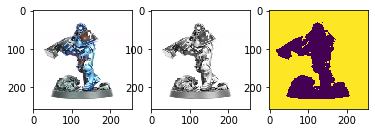

In [4]:
fig, ax = plt.subplots(1,3)
idx = 8

ax[0].imshow(images[idx])
ax[1].imshow(gray_images[idx], cmap="Greys_r")
ax[2].imshow(mask[idx])
plt.show()

In [5]:
import reconstruction

Using TensorFlow backend.


In [6]:
# depths module needs pictures to be 640x480
import numpy as np
padded_images = np.full((images.shape[0], 640, 480, 3), 255)
for i in range(images.shape[0]):
    padded_images[i, 
                  320-images[i].shape[0]//2: 320 + images[i].shape[0]//2,
                  240-images[i].shape[1]//2: 240 + images[i].shape[1]//2, :] = images[i]

depths = reconstruction.depth_estimation(padded_images)

Loading model...
Model loaded (nyu.h5).
Running model...
Done.


In [7]:
images.shape

(53, 256, 256, 3)

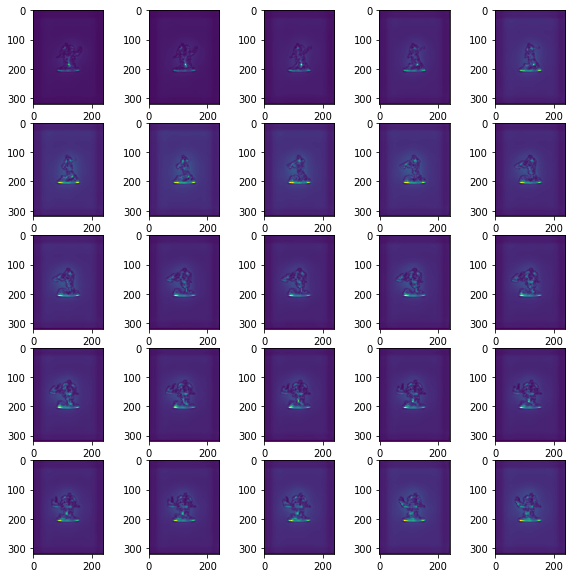

In [8]:
%matplotlib inline
fig, ax = plt.subplots(5,5, figsize=(10,10))
count=0
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(depths[count, :, :, 0])
        count+=1
plt.show()

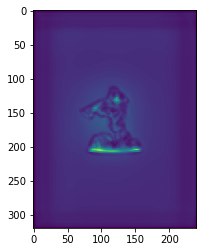

In [9]:
plt.imshow(depths[idx,:,:,0])

plt.show()

In [10]:
from skimage.transform import resize

depths_trunc = depths[1:-2]

small_size = images.shape[1] // 2, images.shape[2] // 2

unpadded_depths = np.zeros((depths_trunc.shape[0], small_size[0], small_size[1]))

depth_masks = np.full((unpadded_depths.shape[0], small_size[0], small_size[1]), False)
print(unpadded_depths.shape[0])
for i in range(unpadded_depths.shape[0]):
    downsamp_mask = resize(mask[i], (small_size[0], small_size[1]))
    depth_masks[i] = downsamp_mask > 0
    unpadded_depths[i] = depths_trunc[i, 
                                160-images[i].shape[0]//4: 160 + images[i].shape[0]//4,
                                120-images[i].shape[1]//4: 120 + images[i].shape[1]//4, 0]
#     print(unpadded_depths[i], unpadded_depths[i].shape)
#     print(downsamp_mask, downsamp_mask.shape)
#     print(unpadded_depths[i][downsamp_mask])
#     unpadded_depths[i][downsamp_mask] = 0

50


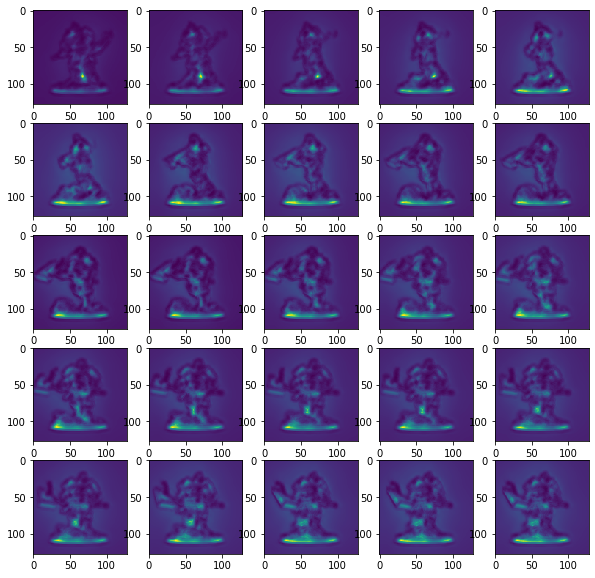

In [11]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
count=0
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(unpadded_depths[count, :, :])
        count+=1
plt.show()

In [12]:
import transformations
tfs = transformations.transforms(gray_images[1:-2], mask)

14234531 14540651
14540651 14796278
14796278 14869622
14869622 14854301
14854301 14808774
14808774 14709920
14709920 14597085
14597085 14464945
14464945 14464891
14464891 14117077
14117077 14117427
14117427 14018576
14018576 13892341
13892341 13802137
13802137 13826740
13826740 13755200
13755200 13805481
13805481 13805524
13805524 13831038
13831038 13830824
13830824 13868694
13868694 14011580
14011580 14011501
14011501 14011554
14011554 14126878
14126878 14468850
14468850 14660758
14660758 14782925
14782925 14882477
14882477 14889048
14889048 14803432
14803432 14719878
14719878 14542504
14542504 14390468
14390468 14020686
14020686 14020382
14020382 13889197
13889197 13889252
13889252 13834962
13834962 13826370
13826370 13882878
13882878 13989965
13989965 14231694
14231694 14390361
14390361 14541656
14541656 14684428
14684428 14799801
14799801 14870032
14870032 14853485


In [ ]:
# Now putting all points in the same frame
points = np.nonzero()